In [193]:
import os
import numpy as np
from scipy.fftpack import dct
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, DetCurveDisplay, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [194]:
def load_dir(dir, n, delim = ''):
    data = []
    for file in os.listdir(dir):
        if delim in file:
            arr = np.loadtxt(dir + file, skiprows = 1)
            arr_transform = dct(arr, axis = 0)[:n, :]
            data.append(arr_transform.flatten())
    return np.array(data)

In [195]:
coast_train_dir = 'Isolated digits/1/train/'
forest_train_dir = 'Isolated digits/2/train/'
highway_train_dir = 'Isolated digits/4/train/'
mountain_train_dir = 'Isolated digits/9/train/'
opencountry_train_dir = 'Isolated digits/o/train/'

coast_dev_dir = 'Isolated digits/1/dev/'
forest_dev_dir = 'Isolated digits/2/dev/'
highway_dev_dir = 'Isolated digits/4/dev/'
mountain_dev_dir = 'Isolated digits/9/dev/'
opencountry_dev_dir = 'Isolated digits/o/dev/'

In [223]:
n = 35

coast_train = load_dir(coast_train_dir, n, delim = '.mfcc')
forest_train = load_dir(forest_train_dir, n, delim = '.mfcc')
highway_train = load_dir(highway_train_dir, n, delim = '.mfcc')
mountain_train = load_dir(mountain_train_dir, n, delim = '.mfcc')
opencountry_train = load_dir(opencountry_train_dir, n, delim = '.mfcc')

coast_dev = load_dir(coast_dev_dir, n, delim = '.mfcc')
forest_dev = load_dir(forest_dev_dir, n, delim = '.mfcc')
highway_dev = load_dir(highway_dev_dir, n, delim = '.mfcc')
mountain_dev = load_dir(mountain_dev_dir, n, delim = '.mfcc')
opencountry_dev = load_dir(opencountry_dev_dir, n, delim = '.mfcc')

In [224]:
X_train = np.concatenate([coast_train, forest_train, highway_train, mountain_train, opencountry_train], axis = 0)
X_dev = np.concatenate([coast_dev, forest_dev, highway_dev, mountain_dev, opencountry_dev], axis = 0)

y_train = np.array([0]*coast_train.shape[0] + [1]*forest_train.shape[0] + [2]*highway_train.shape[0] + [3]*mountain_train.shape[0] + [4]*opencountry_train.shape[0])
y_dev = np.array([0]*coast_dev.shape[0] + [1]*forest_dev.shape[0] + [2]*highway_dev.shape[0] + [3]*mountain_dev.shape[0] + [4]*opencountry_dev.shape[0])

In [225]:
classes = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [226]:
train_true = pd.Series([classes[i] for i in y_train])
dev_true = pd.Series([classes[i] for i in y_dev])

In [227]:
def knn_predict(X_train, y_train, X_test, classes, k = 10):
    m = X_train.shape[0]
    n = X_test.shape[0]
    ref = range(m)
    scores = np.zeros((n, len(classes)))
    for i in range(n):
        test = X_test[i, :]
        score = np.sum((X_train - test)**2, axis = -1)
        sort_idx = sorted(ref, key = lambda x: score[x])[:k]
        for idx in sort_idx:
            scores[i, classes[y_train[idx]]] += 1
    return scores/k

In [228]:
scores_dev = knn_predict(X_train, y_train, X_dev, classes, k = 10)

In [229]:
dev_pred = np.argmax(scores_dev, axis = -1)

In [230]:
def evaluate_classifier(y, scores, thresh = 0.5):
    enc = OneHotEncoder()
    y_sparse = enc.fit_transform(y.to_numpy().reshape(-1, 1)).toarray()
    prob = scores/np.sum(scores, axis = -1)[:, np.newaxis]
    n, c = prob.shape
    cm = np.zeros((2, 2))
    for i in range(c):
        col = []
        for j in range(y.shape[0]):
            if prob[j, i] >= thresh:
                col.append(1)
            else:
                col.append(0)
        cm += confusion_matrix(y_sparse[:, i], col)
    tpr = cm[1, 1]/(cm[1, 1] + cm[1, 0])
    fpr = cm[0, 1]/(cm[0, 1] + cm[0, 0])
    return tpr, fpr, cm

def compute_ROC(y, scores, h = 0.05):
    threshold = [i*h for i in range(int(1/h + 1))]
    tpr, fpr = [], []
    for thresh in threshold:
        a, b, _ = evaluate_classifier(y, scores, thresh = thresh)
        tpr.append(a)
        fpr.append(b)
    return tpr, fpr, threshold

def compute_DET(y, scores, h = 0.05):
    threshold = [i*h for i in range(int(1/h + 1))]
    fpr, fnr = [], []
    for thresh in threshold:
        _, b, cm = evaluate_classifier(y, scores, thresh = thresh)
        fpr.append(b)
        fnr.append(cm[1, 0]/(cm[1, 0] + cm[1, 1]))
    return fpr, fnr, threshold

def plot_confusion_matrix(y, pred, classes, title = 'Development Set'):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(5, 4))
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y, pred), annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix - ' + title, fontsize=20)
    plt.show()

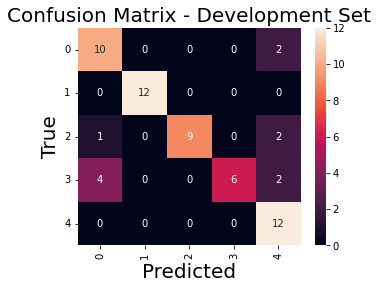

In [231]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [232]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


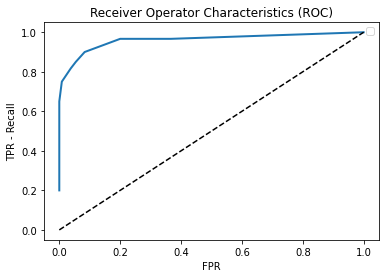

In [233]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

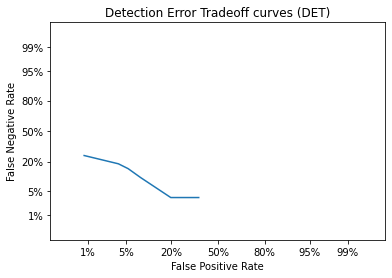

In [234]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

In [235]:
acc = []
k_low = 1
k_high = 100
h = 4
for k in range(k_low, k_high + 1, h):
    scores_dev = knn_predict(X_train, y_train, X_dev, classes, k = k)
    dev_pred = np.argmax(scores_dev, axis = -1)
    acc.append(accuracy_score(dev_true, dev_pred))

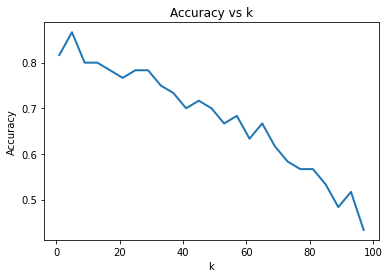

In [236]:
plt.plot(range(k_low, k_high + 1, h), acc, linewidth = 2)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

## Logistic Regression

In [237]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def log_reg_model(X, w, predict = False):
    if predict:
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis = -1)
    return sigmoid(np.dot(X, w))

def compute_grad(p, y, X, w, C, r, stochastic = True):
    batch = X.shape[0]
    if stochastic:
        batch = int(X.shape[0]*r)
    X, y, p = resample(X, y, p, n_samples = batch, replace = False)
    return np.dot((p - y), X)/batch + C*w

def compute_loss(p, y, C, w):
    return -(np.dot(y, np.log(p)) + np.dot(1 - y, np.log(1 - p)))/y.shape[0] + (C/2)*np.linalg.norm(w)

def train_log_reg(X_train, y_train, eta = 0.1, tol = 0.05, max_iter = 10000, C = 0, r = 0.3):
    n, p = X_train.shape
    X_bias = np.concatenate([X_train, np.ones((n, 1))], axis = -1)
    w = np.zeros(p + 1) #np.random.random(p + 1)
    p = log_reg_model(X_bias, w)
    loss = compute_loss(p, y_train, C, w)
    iter = 0
    while loss > tol and iter < max_iter:
        w = w - eta*compute_grad(p, y_train, X_bias, w, C, r)
        p = log_reg_model(X_bias, w)
        loss = compute_loss(p, y_train, C, w)
        iter += 1
    return w, loss, iter

In [238]:
def change_targets(y, c_id):
    y_change = []
    for t in y:
        if t == c_id:
            y_change.append(1)
        else:
            y_change.append(0)
    return np.array(y_change)

In [239]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

In [240]:
targets_train = []
targets_dev = []
for c_id in classes:
    targets_train.append(change_targets(y_train, c_id))
    targets_dev.append(change_targets(y_dev, c_id))

In [241]:
W = []
class_loss = []
for targets in targets_train:
    w, loss, iter = train_log_reg(X_train_scaled, targets)
    W.append(w)
    class_loss.append(loss)

In [242]:
scores_dev = np.zeros((X_dev.shape[0], len(classes)))
for i in range(len(W)):
    p = log_reg_model(X_dev_scaled, W[i], predict = True)
    scores_dev[:, i] = p
scores_dev /= np.sum(scores_dev, axis = -1)[:, np.newaxis]

In [243]:
dev_pred = np.argmax(scores_dev, axis = -1)

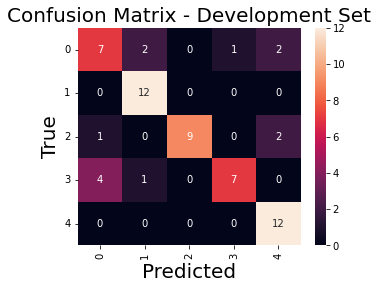

In [244]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [245]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


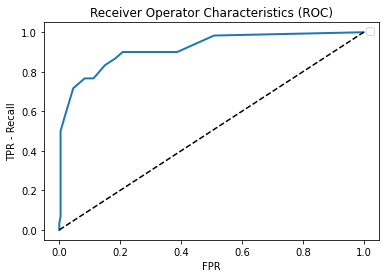

In [246]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

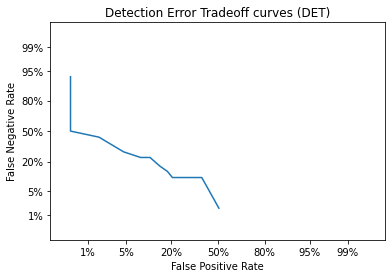

In [247]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

## PCA

In [248]:
def central_data(x):
    x = x.T
    mu = np.mean(x, axis = -1)[:, np.newaxis]
    return (x - mu)

def pca(z):
    z = central_data(z)
    I, t = z.shape
    cov = np.dot(z, z.T)/t
    lam, w = np.linalg.eig(cov)
    w[:, range(I)] = w[:, sorted(range(I), key = lambda x: -lam[x])]
    return w, sorted(lam, reverse = True)

def pca_transform(X, W, k):
    return np.abs(np.dot(central_data(X).T, W[:, :k]))

In [249]:
W, lam = pca(X_train)

Text(0, 0.5, 'Magnitude of eigen value')

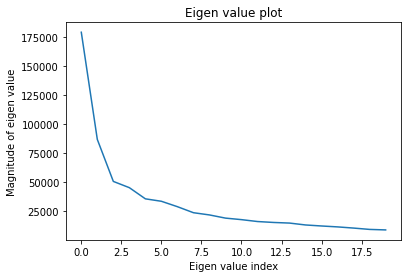

In [250]:
plt.plot(np.abs(lam)[:20])
plt.title('Eigen value plot')
plt.xlabel('Eigen value index')
plt.ylabel('Magnitude of eigen value')
plt.show()

In [251]:
k_pca = 8
X_train_pca = pca_transform(X_train, W, k_pca)
X_dev_pca = pca_transform(X_dev, W, k_pca)

In [252]:
scores_dev = knn_predict(X_train_pca, y_train, X_dev_pca, classes, k = 20)

In [253]:
dev_pred = np.argmax(scores_dev, axis = -1)

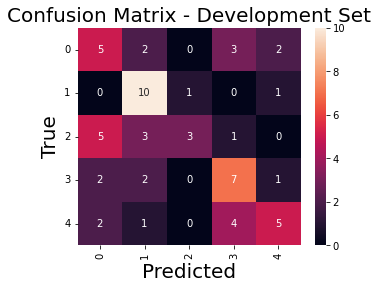

In [254]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [255]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


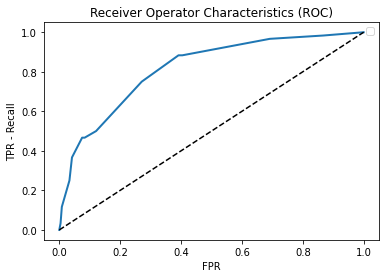

In [256]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

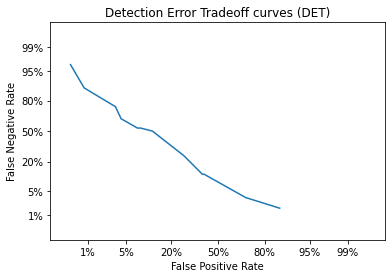

In [257]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

In [258]:
acc = []
k_low = 1
k_high = 100
h = 4
for k in range(k_low, k_high + 1, h):
    scores_dev = knn_predict(X_train_pca, y_train, X_dev_pca, classes, k = k)
    dev_pred = np.argmax(scores_dev, axis = -1)
    acc.append(accuracy_score(dev_true, dev_pred))

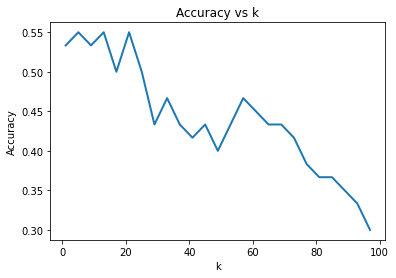

In [259]:
plt.plot(range(k_low, k_high + 1, h), acc, linewidth = 2)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

### Logistic Regression

In [260]:
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_dev_pca = scaler.transform(X_dev_pca)

In [261]:
W = []
class_loss = []
for targets in targets_train:
    w, loss, iter = train_log_reg(X_train_pca, targets)
    W.append(w)
    class_loss.append(loss)

In [262]:
scores_dev = np.zeros((X_dev.shape[0], len(classes)))
for i in range(len(W)):
    p = log_reg_model(X_dev_pca, W[i], predict = True)
    scores_dev[:, i] = p
scores_dev /= np.sum(scores_dev, axis = -1)[:, np.newaxis]

In [263]:
dev_pred = np.argmax(scores_dev, axis = -1)

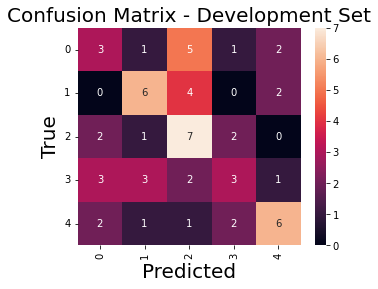

In [264]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [265]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


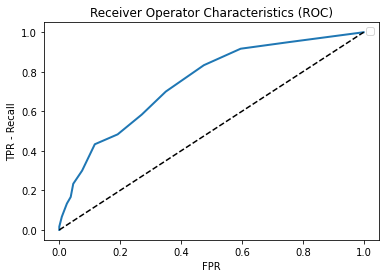

In [266]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

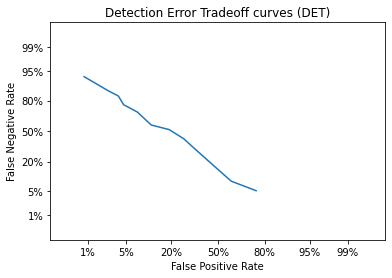

In [267]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

## LDA

In [268]:
def central_data(x):
    x = x.T
    mu = np.mean(x, axis = -1)[:, np.newaxis]
    return (x - mu)

def class_split(X, y, classes):
    data = np.concatenate([X, y[:, np.newaxis]], axis = -1)
    data = pd.DataFrame(data)
    data_class = []
    for c in classes:
        data_class.append(np.array(data[data[X.shape[-1]] == c]))
    return data_class

def lda(X_train, y_train, classes):   
    _, p = X_train.shape
    data_class = class_split(X_train, y_train, classes) 
    Sw = np.zeros((p, p))
    for data in data_class:
        data_center = central_data(data[:, :-1])
        Sw += np.dot(data_center, data_center.T)
    X_train_center = central_data(X_train)
    St = np.dot(X_train_center, X_train_center.T)
    Sb = St - Sw
    T = np.dot(np.linalg.inv(Sw), Sb)
    lam, w = np.linalg.eig(T)
    b = [i for i in range(len(lam)) if not np.imag(lam[i])]
    w = w[:, b]
    lam = lam[b]
    w[:, range(len(b))] = w[:, sorted(range(len(b)), key = lambda x: -lam[x])]
    return w, sorted(lam, reverse = True)

In [269]:
n_components = len(classes) - 1
W, lam = lda(X_train, y_train, classes)

In [271]:
X_train_lda = np.abs(np.dot(X_train, W[:, :n_components]))
X_dev_lda = np.abs(np.dot(X_dev, W[:, :n_components]))

In [272]:
scores_dev = knn_predict(X_train_lda, y_train, X_dev_lda, classes, k = 25)

In [273]:
dev_pred = np.argmax(scores_dev, axis = -1)

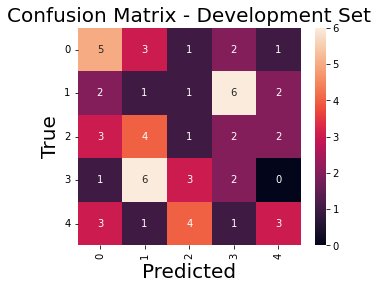

In [274]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [275]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


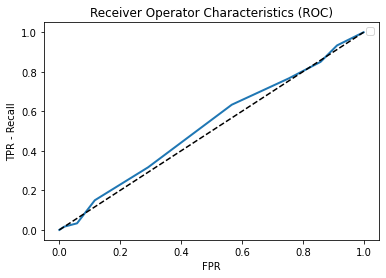

In [276]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

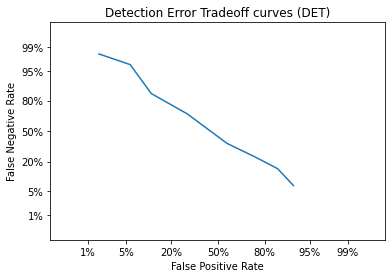

In [277]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

In [278]:
acc = []
k_low = 1
k_high = 200
h = 4
for k in range(k_low, k_high + 1, h):
    scores_dev = knn_predict(X_train_lda, y_train, X_dev_lda, classes, k = k)
    dev_pred = np.argmax(scores_dev, axis = -1)
    acc.append(accuracy_score(dev_true, dev_pred))

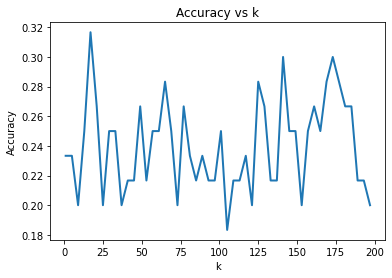

In [279]:
plt.plot(range(k_low, k_high + 1, h), acc, linewidth = 2)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

### Logistic Regression

In [280]:
scaler = StandardScaler()
X_train_lda = scaler.fit_transform(X_train_lda)
X_dev_lda = scaler.transform(X_dev_lda)

In [281]:
W = []
class_loss = []
for targets in targets_train:
    w, loss, iter = train_log_reg(X_train_lda, targets)
    W.append(w)
    class_loss.append(loss)

In [282]:
scores_dev = np.zeros((X_dev.shape[0], len(classes)))
for i in range(len(W)):
    p = log_reg_model(X_dev_lda, W[i], predict = True)
    scores_dev[:, i] = p
scores_dev /= np.sum(scores_dev, axis = -1)[:, np.newaxis]

In [283]:
dev_pred = np.argmax(scores_dev, axis = -1)

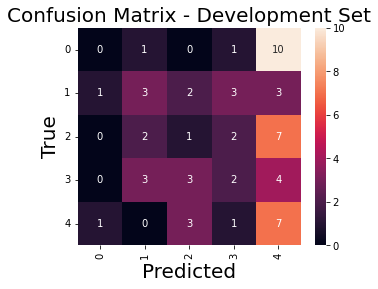

In [284]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [285]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


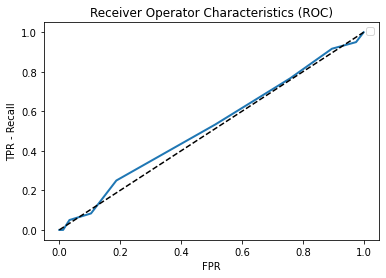

In [286]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

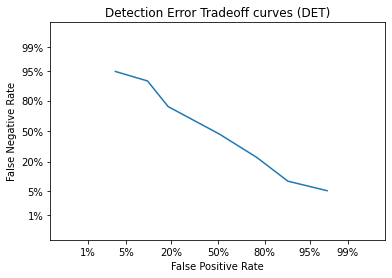

In [287]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()